# Testing Bayesian Optimization for Lab Experiments

This notebook compares the performance of Bayesian Optimization (BayBE) to random sampling for maximizing `PendelumHardness` in a lab experiment dataset.

## Contents
- **Requirements & Setup**: Python version and required packages
- **Data Loading & Exploration**: Import and visualize the dataset
- **Random Sampling Baseline**: Monte Carlo simulation for baseline probabilities
- **Bayesian Optimization Evaluation**: Run and evaluate BayBE campaigns

## Requirements
- Python >= 3.9
- pandas, numpy, seaborn, matplotlib
- baybe (for Bayesian Optimization)


## 1. Setup and Imports

Import all required libraries for data analysis and visualization.

In [19]:
# Python version: >=3.9
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Data Loading & Exploration

Load the dataset and inspect the distribution of the target variable (`PendelumHardness`).

In [20]:
# Load the dataset
data = pd.read_excel('data/DOE_64_runs_fullfact.xlsx')
# Ensure PendelumHardness is float to avoid BayBE warnings
data['PendelumHardness'] = data['PendelumHardness'].astype(float)

# Quick look at the data
display(data.head())

,run_order,Temp_coded,PVC_coded,CatalystConc_coded,Crosslinking_coded,CatalystType_coded,HardenerType_coded,PendelumHardness
0,1,-1,1,-1,-1,-1,1,71.0
1,2,1,1,-1,-1,-1,1,98.0
2,3,-1,1,-1,1,-1,1,78.0
3,4,1,1,-1,1,-1,1,99.0
4,5,-1,1,-1,-1,-1,-1,69.0


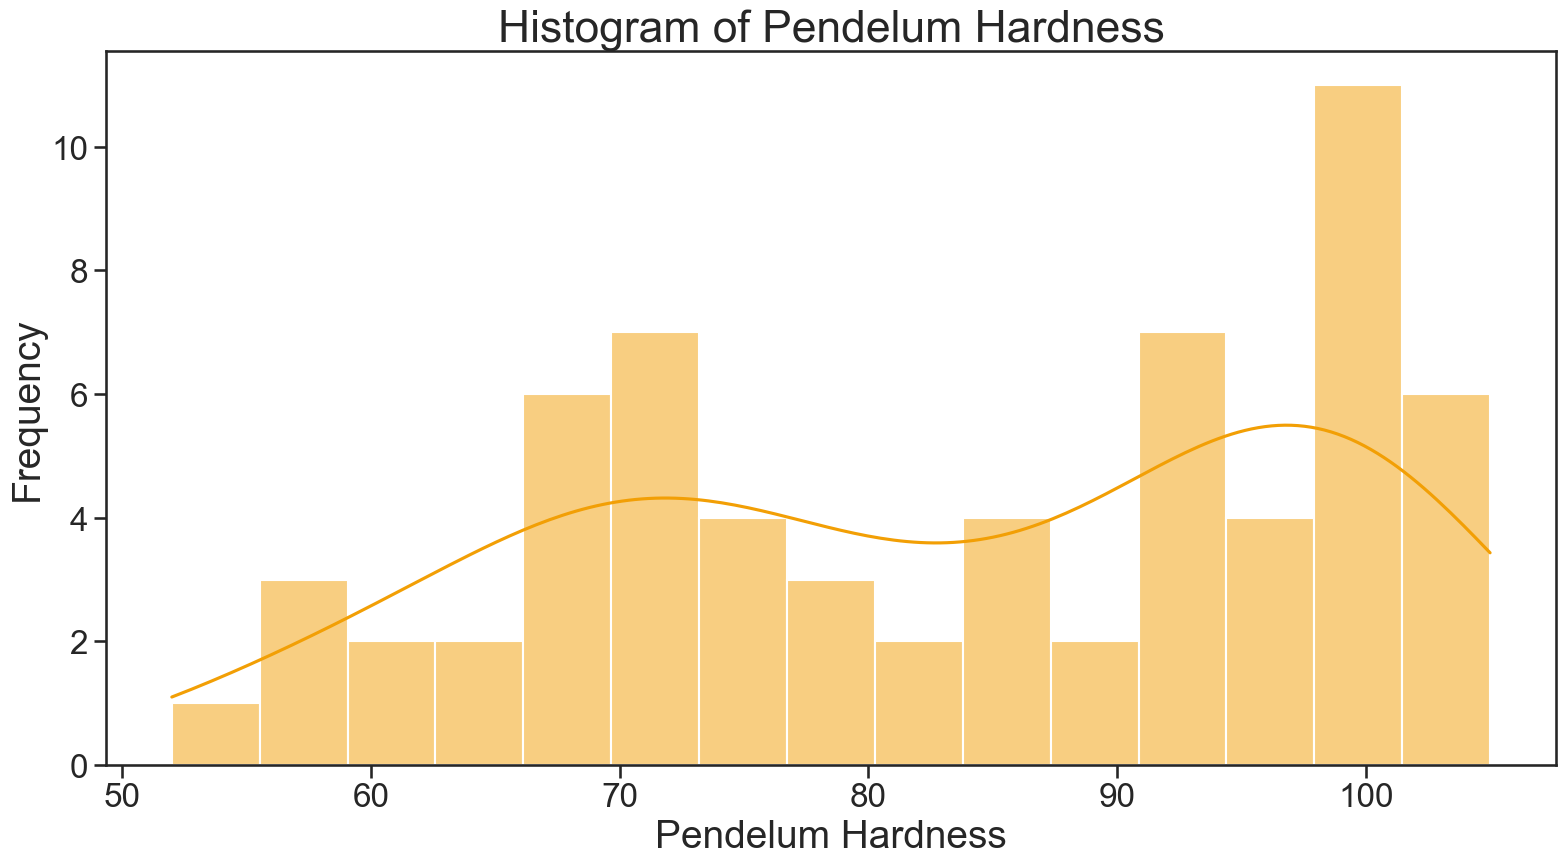

In [21]:
# Plot the distribution of PendelumHardness
sns.set_theme(style="ticks")
sns.set_context(
    "talk",
    rc={
        "font.size": 18,
        "axes.titlesize": 32,
        "axes.labelsize": 28,
        "xtick.labelsize": 24,
        "ytick.labelsize": 24
    },
)

fig, ax = plt.subplots(figsize=(16, 9))
sns.histplot(
    data["PendelumHardness"],
    bins=15,
    color="#F29F05",
    kde=True,
    ax=ax
)
ax.set_title("Histogram of Pendelum Hardness")
ax.set_xlabel("Pendelum Hardness")
ax.set_ylabel("Frequency")
plt.tight_layout()
plt.show()

## 3. Random Sampling Baseline

Estimate the probability that random sampling would yield at least one value above various thresholds for `PendelumHardness`. This provides a baseline to compare against BayBE.

**Method:** Monte Carlo simulation (default: 100,000 iterations, 10 samples per iteration).

In [22]:
def random_sampling_probabilities(data, target_col, n_samples=10, thresholds=[90, 100, 101, 102, 103], n_iter=100000, seed=42):
    """
    Monte Carlo simulation: probability that max of n_samples exceeds each threshold.
    """
    np.random.seed(seed)
    results = {t: 0 for t in thresholds}
    data_array = data[target_col].dropna().values
    for _ in range(n_iter):
        sample = np.random.choice(data_array, size=n_samples, replace=False)
        max_val = np.max(sample)
        for t in thresholds:
            if max_val > t:
                results[t] += 1
    # Convert counts to probabilities
    for t in thresholds:
        results[t] = results[t] / n_iter
    return pd.DataFrame({
        "Threshold": thresholds,
        "Probability max(sample) > threshold": [f"{results[t]*100:.2f}%" for t in thresholds],
        "N datapoints above threshold": [(data[target_col] > t).sum() for t in thresholds]
    })

prob_df = random_sampling_probabilities(data, "PendelumHardness")
display(prob_df)

,Threshold,Probability max(sample) > threshold,N datapoints above threshold
0,90,99.82%,28
1,100,71.73%,7
2,101,65.72%,6
3,102,50.38%,4
4,103,15.73%,1


**Interpretation:**

- For thresholds below 100, random sampling is likely to succeed.
- For thresholds above 100, random sampling success drops sharply.
- BayBE must outperform these probabilities to be considered effective.

## 4. Bayesian Optimization (BayBE) Evaluation

Run BayBE campaigns and compare their success rate to the random baseline.

### 4.1 Random Recommender (Control)

This section runs BayBE with a random recommender to serve as a control.

In [33]:
# --- BayBE imports ---
from baybe import Campaign
from baybe.targets import NumericalTarget
from baybe.objectives import SingleTargetObjective
from baybe.parameters import NumericalDiscreteParameter
from baybe.searchspace import SearchSpace
from baybe.recommenders import FPSRecommender, TwoPhaseMetaRecommender, RandomRecommender

# --- Prepare look-up table ---
look_up = pd.read_excel("data/DOE_64_runs_fullfact.xlsx")
look_up['PendelumHardness'] = look_up['PendelumHardness'].astype(float)

def create_campaign_random(seed=None):
    """Create a BayBE campaign with a random recommender."""
    if seed is not None:
        np.random.seed(seed)
    target = NumericalTarget(name="PendelumHardness", mode="MAX")
    objective = SingleTargetObjective(target=target)
    parameters = [
        NumericalDiscreteParameter("Temp_coded", [-1, 1], tolerance=0.1),
        NumericalDiscreteParameter("PVC_coded", [-1, 1], tolerance=0.1),
        NumericalDiscreteParameter("CatalystConc_coded", [-1, 1], tolerance=0.1),
        NumericalDiscreteParameter("Crosslinking_coded", [-1, 1], tolerance=0.1),
        NumericalDiscreteParameter("CatalystType_coded", [-1, 1], tolerance=0.1),
        NumericalDiscreteParameter("HardenerType_coded", [-1, 1], tolerance=0.1),
    ]
    searchspace = SearchSpace.from_product(parameters)
    recommender = TwoPhaseMetaRecommender(
        initial_recommender=FPSRecommender(),
        recommender=RandomRecommender(),
    )
    return Campaign(searchspace, objective, recommender)

def run_single_campaign(look_up, n_cycles=3, batch_size=3, threshold=102, seed=None):
    """Run one campaign and return True if any value exceeds threshold."""
    camp = create_campaign_random(seed=seed)
    best_value = -np.inf
    for _ in range(n_cycles):
        df_rec = camp.recommend(batch_size=batch_size)
        merge_cols = df_rec.columns.tolist()
        df_meas = pd.merge(
            df_rec,
            look_up[merge_cols + ["PendelumHardness"]],
            on=merge_cols,
            how="left",
        )
        camp.add_measurements(df_meas)
        best_value = max(best_value, df_meas["PendelumHardness"].max())
    return best_value > threshold

# --- Run multiple campaigns ---
N_RUNS = 100
BATCH_SIZE = 5
N_CYCLES = 2
THRESHOLD = 102
success_flags = [
    run_single_campaign(look_up, n_cycles=N_CYCLES, batch_size=BATCH_SIZE, threshold=THRESHOLD, seed=seed)
    for seed in range(N_RUNS)
]
n_success = sum(success_flags)
success_rate = n_success / N_RUNS
print(f"Random recommender exceeded {THRESHOLD} in {n_success}/{N_RUNS} campaigns ({success_rate*100:.1f}%).")

Random recommender exceeded 102 in 50/100 campaigns (50.0%).


### 4.2 Bayesian Optimization (BayBE) with Surrogate Model

Now run BayBE with a Bayesian surrogate model (Random Forest) for exploitation. I used the Random Forest surrogate model because it showed the best performance.

In [34]:
from baybe.recommenders import BotorchRecommender
from baybe.surrogates import RandomForestSurrogate

def create_campaign_bayesian(seed=None):
    """Create a BayBE campaign with Bayesian recommender."""
    if seed is not None:
        np.random.seed(seed)
    target = NumericalTarget(name="PendelumHardness", mode="MAX")
    objective = SingleTargetObjective(target=target)
    parameters = [
        NumericalDiscreteParameter("Temp_coded", [-1, 1], tolerance=0.1),
        NumericalDiscreteParameter("PVC_coded", [-1, 1], tolerance=0.1),
        NumericalDiscreteParameter("CatalystConc_coded", [-1, 1], tolerance=0.1),
        NumericalDiscreteParameter("Crosslinking_coded", [-1, 1], tolerance=0.1),
        NumericalDiscreteParameter("CatalystType_coded", [-1, 1], tolerance=0.1),
        NumericalDiscreteParameter("HardenerType_coded", [-1, 1], tolerance=0.1),
    ]
    searchspace = SearchSpace.from_product(parameters)
    recommender = TwoPhaseMetaRecommender(
        initial_recommender=FPSRecommender(),
        recommender=BotorchRecommender(surrogate_model=RandomForestSurrogate()),
    )
    return Campaign(searchspace, objective, recommender)

def run_single_campaign_bayes(look_up, n_cycles=3, batch_size=3, threshold=102, seed=None):
    """Run one campaign and return True if any value exceeds threshold."""
    camp = create_campaign_bayesian(seed=seed)
    best_value = -np.inf
    for _ in range(n_cycles):
        df_rec = camp.recommend(batch_size=batch_size)
        merge_cols = df_rec.columns.tolist()
        df_meas = pd.merge(
            df_rec,
            look_up[merge_cols + ["PendelumHardness"]],
            on=merge_cols,
            how="left",
        )
        camp.add_measurements(df_meas)
        best_value = max(best_value, df_meas["PendelumHardness"].max())
    return best_value > threshold

# --- Run multiple campaigns ---
success_flags_bayes = [
    run_single_campaign_bayes(look_up, n_cycles=N_CYCLES, batch_size=BATCH_SIZE, threshold=THRESHOLD, seed=seed)
    for seed in range(N_RUNS)
]
n_success_bayes = sum(success_flags_bayes)
success_rate_bayes = n_success_bayes / N_RUNS
print(f"Bayesian recommender exceeded {THRESHOLD} in {n_success_bayes}/{N_RUNS} campaigns ({success_rate_bayes*100:.1f}%).")

Bayesian recommender exceeded 102 in 85/100 campaigns (85.0%).
